In [1]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [4]:
#Setting the batchsize to 64
numb_batch = 64

In [5]:
# Getting data
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [6]:
#creating the model
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [7]:
# Validating the model
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [8]:
# Training function
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

In [9]:
# GPU Availability
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

Saving Best Model with Accuracy:  95.91999816894531
Epoch: 1 Accuracy : 95.91999816894531 %
Saving Best Model with Accuracy:  97.02999877929688
Epoch: 2 Accuracy : 97.02999877929688 %
Saving Best Model with Accuracy:  97.13999938964844
Epoch: 3 Accuracy : 97.13999938964844 %
Saving Best Model with Accuracy:  98.45999908447266
Epoch: 4 Accuracy : 98.45999908447266 %
Saving Best Model with Accuracy:  98.70999908447266
Epoch: 5 Accuracy : 98.70999908447266 %
Saving Best Model with Accuracy:  98.72000122070312
Epoch: 6 Accuracy : 98.72000122070312 %
Epoch: 7 Accuracy : 98.62000274658203 %
Saving Best Model with Accuracy:  98.76000213623047
Epoch: 8 Accuracy : 98.76000213623047 %
Epoch: 9 Accuracy : 98.66000366210938 %
Saving Best Model with Accuracy:  98.9000015258789
Epoch: 10 Accuracy : 98.9000015258789 %
Epoch: 11 Accuracy : 98.79000091552734 %
Epoch: 12 Accuracy : 98.88999938964844 %
Saving Best Model with Accuracy:  98.94999694824219
Epoch: 13 Accuracy : 98.94999694824219 %
Epoch: 14 

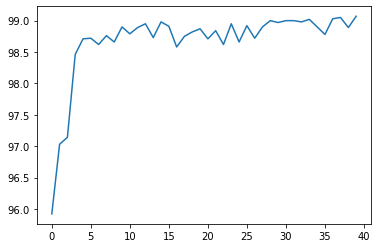

In [10]:
# Training the model
lenet = train(40, device=device)

In [11]:
# Saving the model
torch.save(lenet.state_dict(), "lenet.pth")

In [12]:
#  Loading the saved model
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()


Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
# Creating the function to test validation data
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [14]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [15]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,976,0,1,0,0,0,1,1,1,0
1,0,1133,0,0,0,1,0,0,0,1
2,1,2,1024,0,1,0,0,3,1,0
3,0,0,2,1001,0,1,0,1,3,2
4,0,0,1,0,975,0,2,1,0,3
5,1,0,0,6,0,883,1,0,1,0
6,5,2,0,1,2,2,946,0,0,0
7,1,1,4,0,0,0,0,1020,1,1
8,5,0,3,2,0,0,1,2,957,4
9,0,1,0,1,8,6,0,1,0,992


In [22]:
# defining function to get prediction 
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [23]:
# getting the image from web
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

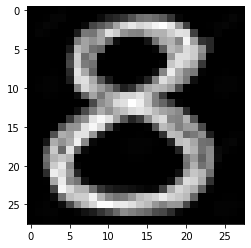

In [24]:

# showing the image
plt.imshow(x.squeeze(-1), cmap="gray")

In [25]:
# predictions
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 100.0 %


In [26]:
pred

array([[1.6744826e-20, 2.0098827e-11, 8.7707992e-09, 7.5801598e-10,
        9.6365355e-12, 1.2378123e-13, 3.6993179e-13, 1.5934597e-16,
        1.0000000e+00, 6.3568380e-19]], dtype=float32)